<a href="https://colab.research.google.com/github/Molter73/ai-class/blob/main/viajante/Problema_del_Vendedor_Ambulante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema del Viajante

https://es.wikipedia.org/wiki/Problema_del_viajante


Dada una lista de ciudades y las distancias entre ellas, las capitales de todas las provincias españolas, por ejemplo, ¿cual es la ruta mas corta que visita cada ciudad y regresa a la ciudad original?

Cuaderno adaptado de:

https://colab.research.google.com/github/Albina1810/tsp/blob/master/TSP.ipynb

Por Prof. Hector Barrio Crespo.


Universidad Europea, 2021
Revisado Octubre 2022

# Intercambio par a par
El intercambio par a par o técnica 2-opt involucra en cada iteración la eliminación de dos aristas y el reemplazo de estas con dos aristas diferentes que reconecten los fragmentos creados por la eliminación de las aristas produciendo un camino nuevo más corto. Esto es un caso especial del método k-opt.

Note que la etiqueta Lin–Kernighan es un nombre erróneo para el 2-opt muchas veces utilizado. Lin–Kernighan es realmente el método más general de k-opt (https://en.wikipedia.org/wiki/2-opt).

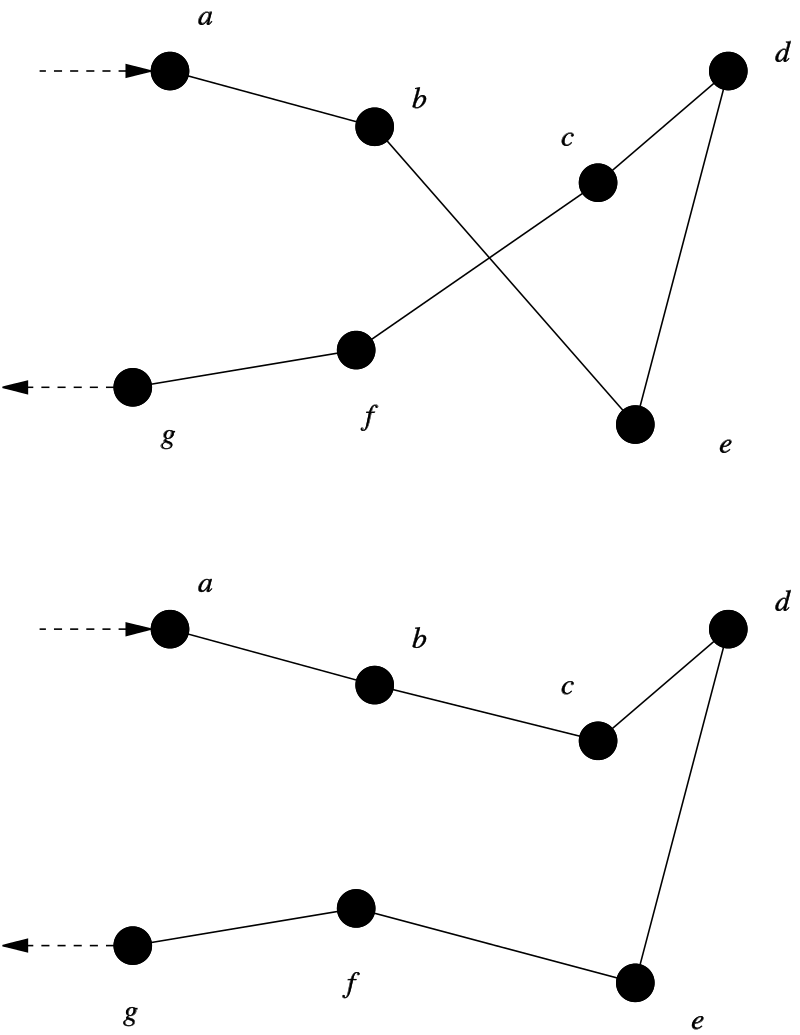

In [1]:
import numpy as np
import pandas as pd
from math import radians, cos, sin
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
# Calculamos la distancia euclidiana en espacio de la ruta r por la ciudad c,
# terminando al inicio:
distancia_ruta = lambda r, c: np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]])
                                    for p in range(len(r))])

# Invertir el orden de los elementos desde i a k en r:
inversion = lambda r, i, k: np.concatenate((r[0:i],
                                            r[k:-len(r)+i-1:-1],
                                            r[k+1:len(r)]))

def two_opt(ciudades, umbral_mejora):
    # Vector de filas con las ciudades:
    ruta = np.arange(ciudades.shape[0])
    # Inicializar el factor de mejora:
    f_mejora = 1
    # Calcular la distancia de la primera ruta:
    mejor_dist = distancia_ruta(ruta, ciudades)

    # Si la ruta mejora seguimos optimizando:
    while f_mejora > umbral_mejora:
        # Guardamos la mejor distancia obtenida:
        dist_a_mejorar = mejor_dist

        # Para cada ciudad, excluyendo la primera y la ultima:
        for cambiar_primera in range(1, len(ruta)-2):
            # Para cada ciudad subsiguiente:
            for cambiar_ultima in range(cambiar_primera + 1, len(ruta)):
                # Invertimos el orden de las ciudades:
                nueva_ruta = inversion(ruta, cambiar_primera, cambiar_ultima)
                # Comprobamos la distancia con este cambio:
                nueva_distancia = distancia_ruta(nueva_ruta, ciudades)

                # Si ha mejorado la distancia:
                if nueva_distancia < mejor_dist:
                    # Esta es nuestra nueva mejor ruta:
                    ruta = nueva_ruta
                    # Esta es nuestra mejor distancia:
                    mejor_dist = nueva_distancia
        # Calculamos cuanto ha mejorado la ruta:
        f_mejora = 1 - mejor_dist/dist_a_mejorar
        # Si la ruta no mejora de manera sustancial, devolvemos la ruta:
    return ruta

# **Importar csv con Longitud y Latitud de las ciudades**

Importamos un archivo json con longitud y latitud de ciudades, en este caso ciudades de Argentina extraidas de https://simplemaps.com/static/data/country-cities/ar/ar.json

In [3]:
![[ -f /content/ar.json ]] || wget https://raw.githubusercontent.com/Molter73/ai-class/main/viajante/ar.json

--2023-10-18 09:09:44--  https://raw.githubusercontent.com/Molter73/ai-class/main/viajante/ar.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87831 (86K) [text/plain]
Saving to: ‘ar.json’

ar.json             100%[===================>]  85.77K  --.-KB/s    in 0.03s   

2023-10-18 09:09:44 (3.26 MB/s) - ‘ar.json’ saved [87831/87831]



In [4]:
ciudades = pd.read_json("/content/ar.json")
ciudades = ciudades.drop(['admin_name', 'population', 'iso2', 'country', 'population_proper', 'capital'], 1)
ciudades.head(10)

<ipython-input-4-8051ce96b2fd>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ciudades = ciudades.drop(['admin_name', 'population', 'iso2', 'country', 'population_proper', 'capital'], 1)


,city,lat,lng
0,Buenos Aires,-34.5997,-58.3819
1,Córdoba,-31.4167,-64.1833
2,Rosario,-32.9575,-60.6394
3,Santiago del Estero,-27.7833,-64.2667
4,Comodoro Rivadavia,-45.8647,-67.4808
5,Mar del Plata,-38.0000,-57.5500
6,San Miguel de Tucumán,-26.8167,-65.2167
7,Salta,-24.7833,-65.4167
8,San Juan,-31.5342,-68.5261
9,Lanús,-34.7000,-58.4000


In [5]:
ciudades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    485 non-null    object 
 1   lat     485 non-null    float64
 2   lng     485 non-null    float64
dtypes: float64(2), object(1)
memory usage: 11.5+ KB


# **Convertidor de Latitud y Longitud a Coordenadas Cartesianas**

** R de la tierra =6371 KM**


 x = R * cos( radiance(lat) ) * cos(radiance (lon))


 y = R * cos( radiance(lat) ) * sin(radiance (lon))


 http://www.geomidpoint.com/example.html





In [6]:
R = 6371
lat = ciudades["lat"].map(radians)
lon = ciudades["lng"].map(radians)
x = lon.map(cos) * lat.map(cos) * R
y = lon.map(cos) * lat.map(sin) * R

ciudades["lat_rads"] = lat
ciudades["lon_rads"] = lon
ciudades["x"] = x
ciudades["y"] = y
ciudades.head()

,city,lat,lng,lat_rads,lon_rads,x,y
0,Buenos Aires,-34.5997,-58.3819,-0.603879,-1.018956,2749.308655,-1896.599755
1,Córdoba,-31.4167,-64.1833,-0.548325,-1.120210,2367.780061,-1446.246566
2,Rosario,-32.9575,-60.6394,-0.575217,-1.058357,2621.041844,-1699.361682
3,Santiago del Estero,-27.7833,-64.2667,-0.484910,-1.121666,2447.284411,-1289.395237
4,Comodoro Rivadavia,-45.8647,-67.4808,-0.800490,-1.177762,1699.140183,-1751.216443


In [7]:
ciudades_d = ciudades.drop(["lng","lat", "lat_rads", "lon_rads"], 1)
# Limitado a 100 ciudades para que se resuelva en una cantidad de tiempo decente.
# Comentar la siguiente línea para utilizar todas las entradas.
ciudades_d = ciudades_d.head(100)

<ipython-input-7-48a9b0080b77>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ciudades_d = ciudades.drop(["lng","lat", "lat_rads", "lon_rads"], 1)


In [8]:
ciudades_d.set_index('city', inplace=True)

In [9]:
ciudades_d.head()

,x,y
city,,
Buenos Aires,2749.308655,-1896.599755
Córdoba,2367.780061,-1446.246566
Rosario,2621.041844,-1699.361682
Santiago del Estero,2447.284411,-1289.395237
Comodoro Rivadavia,1699.140183,-1751.216443


In [10]:
df = ciudades_d.copy()

In [11]:
scaler = MinMaxScaler(feature_range=(0, 100), copy=True)
df_escalado = scaler.fit_transform(df)
df_escalado = pd.DataFrame(df_escalado, columns=['x1', 'x2'])

In [12]:
df_escalado

,x1,x2
0,69.820309,20.383218
1,50.026437,64.514989
2,63.165770,39.711305
3,54.151158,79.885429
4,15.337106,34.629865
...,...,...
95,58.837933,100.000000
96,68.975996,21.366060
97,73.078332,52.579223
98,69.150117,21.024304


In [13]:
%load_ext google.colab.data_table
df_escalado

,x1,x2
0,69.820309,20.383218
1,50.026437,64.514989
2,63.165770,39.711305
3,54.151158,79.885429
4,15.337106,34.629865
...,...,...
95,58.837933,100.000000
96,68.975996,21.366060
97,73.078332,52.579223
98,69.150117,21.024304


In [14]:
ciudades_d = np.asarray(ciudades_d)

In [15]:
escalado = np.asarray(df_escalado)
escalado

array([[ 69.8203086 ,  20.38321844],
       [ 50.02643704,  64.51498869],
       [ 63.16576991,  39.71130478],
       [ 54.15115773,  79.88542905],
       [ 15.33710555,  34.62986547],
       [ 66.93903119,   0.        ],
       [ 50.83822562,  88.17249659],
       [ 52.02644612,  97.3641218 ],
       [ 30.31637252,  86.70540935],
       [ 69.57473136,  20.00749437],
       [ 69.84407586,  18.84209082],
       [ 64.90738563,  45.99330473],
       [ 79.01209234,  57.05775773],
       [ 53.18141555,  99.36590731],
       [ 47.19839032,  24.51996105],
       [ 78.31083816,  57.9486633 ],
       [ 91.7539424 ,  45.34095677],
       [ 70.08397015,  19.22504958],
       [ 65.48746676,  44.68999982],
       [ 68.30857845,  21.90222531],
       [ 68.58416895,  20.84268194],
       [ 83.56068363,  61.00576078],
       [ 23.20772562,  59.61521201],
       [ 69.55605074,  19.68452613],
       [ 68.40192444,  22.80109606],
       [ 70.98410414,  16.60934789],
       [ 27.37364702,  83.7348711 ],
 

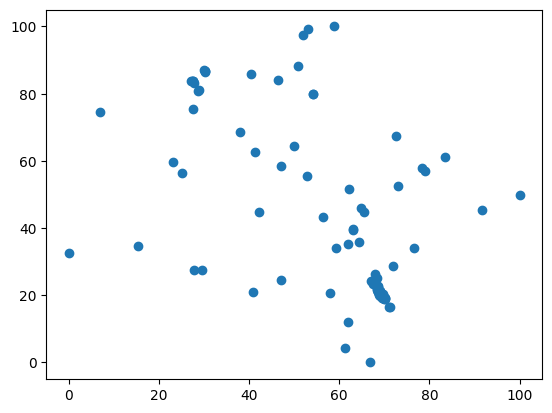

In [16]:
# Mostramos las Ciudades.
plt.scatter(escalado[:, 0], escalado[:, 1]);


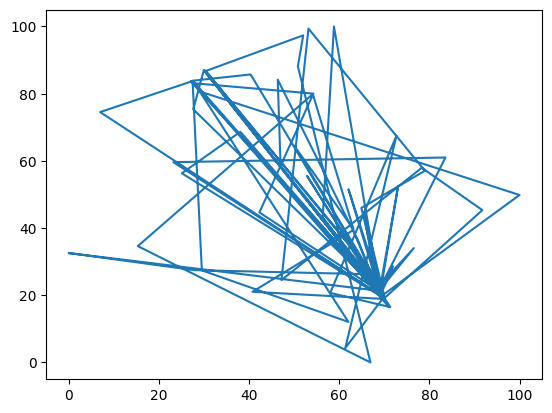

In [17]:
# Mostramos la ruta inicial, estan organizadas en orden alfabetico.
plt.plot(escalado[:, 0], escalado[:, 1])
plt.show()

# Busqueda de Rutas

In [18]:
#  Encontramos una buena ruta (la ruta da el orden de viaje por numero de fila)
ruta = two_opt(escalado, 0.001)
ruta

array([ 0, 93, 54, 33, 70, 41, 98, 27, 20, 39, 69, 44, 68, 96, 63, 42, 56,
       62, 19, 37, 82, 24, 81, 88, 58, 79, 65, 55, 38, 16, 86, 21, 74, 15,
       12, 97, 71, 11, 18,  2, 89, 34, 77, 80, 94, 61, 92, 36,  1,  3, 60,
        6, 95, 13,  7, 35, 29, 57,  8, 78, 84, 28, 49, 26, 99, 59, 46, 85,
       31, 52, 45, 50, 22, 32, 67,  4, 66, 48, 90, 14, 75, 47, 73,  5, 76,
       25, 91, 30, 17, 53, 72, 10, 64, 40, 83, 43, 23, 51, 87,  9])

In [19]:
# Diagrama Cartesiano
# Reordenamos la matriz por ruta:
nuevo_orden = np.concatenate((np.array([escalado[ruta[i]]
                                        for i in range(len(ruta))]),
                              np.array([escalado[0]])))

In [20]:
nuevo_orden

array([[ 69.8203086 ,  20.38321844],
       [ 69.24028789,  20.44075344],
       [ 69.10446106,  19.81364325],
       [ 68.87400818,  20.00130146],
       [ 69.00723474,  20.6341811 ],
       [ 68.99691527,  20.87869868],
       [ 69.15011734,  21.02430369],
       [ 68.83354773,  20.97688299],
       [ 68.58416895,  20.84268194],
       [ 68.6697699 ,  21.0758238 ],
       [ 68.89052861,  21.13241351],
       [ 68.98630999,  21.1226787 ],
       [ 69.07068503,  21.2847259 ],
       [ 68.97599559,  21.36606024],
       [ 68.78379383,  21.38705453],
       [ 68.55267995,  21.57373481],
       [ 68.55267995,  21.57373481],
       [ 68.45708082,  21.58430459],
       [ 68.30857845,  21.90222531],
       [ 68.57690583,  22.45980718],
       [ 68.66175966,  22.69293645],
       [ 68.40192444,  22.80109606],
       [ 67.48738487,  23.30696148],
       [ 67.89961402,  23.84892706],
       [ 66.9608987 ,  24.33338464],
       [ 68.37984511,  25.21940381],
       [ 68.04179041,  26.21793662],
 

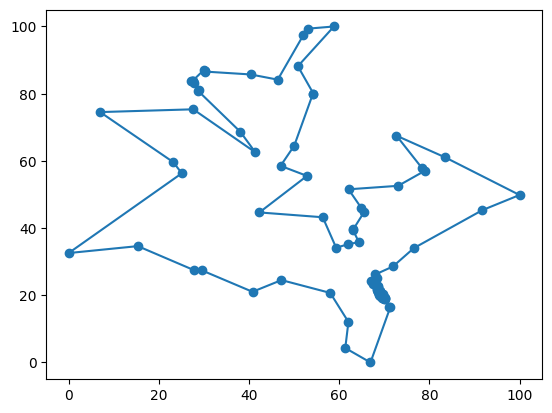

Ruta: [ 0 93 54 33 70 41 98 27 20 39 69 44 68 96 63 42 56 62 19 37 82 24 81 88
 58 79 65 55 38 16 86 21 74 15 12 97 71 11 18  2 89 34 77 80 94 61 92 36
  1  3 60  6 95 13  7 35 29 57  8 78 84 28 49 26 99 59 46 85 31 52 45 50
 22 32 67  4 66 48 90 14 75 47 73  5 76 25 91 30 17 53 72 10 64 40 83 43
 23 51 87  9]

Distancia Escalada: 509.4187546514772


In [21]:
# Mostramos las Ciudades.
plt.scatter(escalado[:,0], escalado[:,1])
# Mostramos la Ruta.
plt.plot(nuevo_orden[:,0], nuevo_orden[:,1])
plt.show()
# Imprimimos la ruta y la distancia:
print("Ruta: " + str(ruta) + "\n\nDistancia Escalada: "
      + str(distancia_ruta(ruta, escalado)))

In [22]:
orden = pd.DataFrame(ruta, columns=["index"])
ciudades["index"] = ciudades.index
viaje = orden.merge(ciudades, on = "index")
viaje

,index,city,lat,lng,lat_rads,lon_rads,x,y
0,0,Buenos Aires,-34.5997,-58.3819,-0.603879,-1.018956,2749.308655,-1896.599755
1,93,Villa Celina,-34.7006,-58.4825,-0.605640,-1.020712,2738.128705,-1896.012625
2,54,Esteban Echeverría,-34.8167,-58.4667,-0.607666,-1.020436,2735.510631,-1902.412121
3,33,José María Ezeiza,-34.8333,-58.5167,-0.607956,-1.021309,2731.068632,-1900.497118
4,70,Ciudad General Belgrano,-34.7167,-58.5333,-0.605921,-1.021599,2733.636586,-1894.038746
...,...,...,...,...,...,...,...,...
95,43,Temperley,-34.7667,-58.3833,-0.606793,-1.018981,2743.660065,-1904.529503
96,23,Banfield,-34.7500,-58.3833,-0.606502,-1.018981,2744.215062,-1903.729727
97,51,Lomas de Zamora,-34.7667,-58.4000,-0.606793,-1.019272,2742.360912,-1903.627687
98,87,Remedios de Escalada,-34.7167,-58.4000,-0.605921,-1.019272,2744.021096,-1901.233801


In [23]:
inicio = viaje[0:1]
ciclo = viaje.append(inicio)
ciclo

<ipython-input-23-13178ab9a8cd>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ciclo = viaje.append(inicio)


,index,city,lat,lng,lat_rads,lon_rads,x,y
0,0,Buenos Aires,-34.5997,-58.3819,-0.603879,-1.018956,2749.308655,-1896.599755
1,93,Villa Celina,-34.7006,-58.4825,-0.605640,-1.020712,2738.128705,-1896.012625
2,54,Esteban Echeverría,-34.8167,-58.4667,-0.607666,-1.020436,2735.510631,-1902.412121
3,33,José María Ezeiza,-34.8333,-58.5167,-0.607956,-1.021309,2731.068632,-1900.497118
4,70,Ciudad General Belgrano,-34.7167,-58.5333,-0.605921,-1.021599,2733.636586,-1894.038746
...,...,...,...,...,...,...,...,...
96,23,Banfield,-34.7500,-58.3833,-0.606502,-1.018981,2744.215062,-1903.729727
97,51,Lomas de Zamora,-34.7667,-58.4000,-0.606793,-1.019272,2742.360912,-1903.627687
98,87,Remedios de Escalada,-34.7167,-58.4000,-0.605921,-1.019272,2744.021096,-1901.233801
99,9,Lanús,-34.7000,-58.4000,-0.605629,-1.019272,2744.575132,-1900.433921


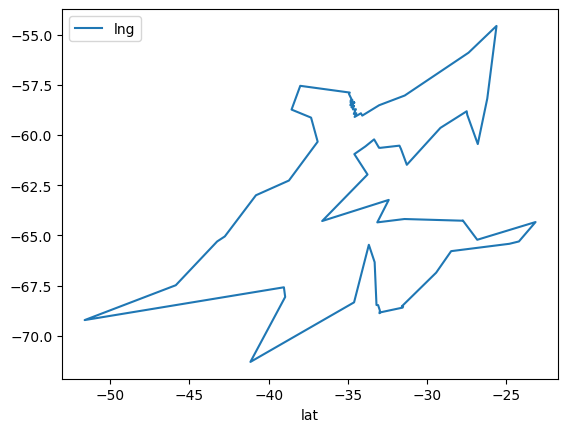

In [24]:
# Dibujar Latitud y Longitud
ciclo.plot(kind="line", x="lat", y="lng");

# Representacion de las Rutas

In [25]:
# Escribimos la ruta como puntos:
viajante = ciclo[["lat", "lng"]]

In [26]:
viajante

,lat,lng
0,-34.5997,-58.3819
1,-34.7006,-58.4825
2,-34.8167,-58.4667
3,-34.8333,-58.5167
4,-34.7167,-58.5333
...,...,...
96,-34.7500,-58.3833
97,-34.7667,-58.4000
98,-34.7167,-58.4000
99,-34.7000,-58.4000


In [27]:
viajante.iloc[0]

lat   -34.5997
lng   -58.3819
Name: 0, dtype: float64

In [28]:
import folium

In [29]:
mapa = folium.Map(location=viajante.iloc[0], zoom_start=5)
puntos_totales = len(viajante)
for i in range(0, puntos_totales):
  x = viajante.iloc[i]['lat']
  y = viajante.iloc[i]['lng']
  punto = [x, y]
  ciudad = ciclo.iloc[i][0]

  if i == 0 or i == puntos_totales - 1:
    color = 'black'
  else:
    color = 'blue'

  icon = folium.Icon(color=color)
  # folium.Marker(punto, popup=ciudad, icon=icon).add_to(mapa)

  if i != 0:
    x_ant = viajante.iloc[i-1]['lat']
    y_ant = viajante.iloc[i-1]['lng']
    punto_anterior = [x_ant, y_ant]
    folium.PolyLine([punto, punto_anterior],
                  color='red',
                  weight=15,
                  opacity=0.8).add_to(mapa)


mapa